## Dependencies

In [1]:
import warnings, json, random, os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, losses, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    

SEED = 0
seed_everything(SEED)
warnings.filterwarnings('ignore')

# Model parameters

In [2]:
config = {
  "BATCH_SIZE": 64,
  "EPOCHS": 100,
  "LEARNING_RATE": 1e-3,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BATCH_SIZE': 64,
 'EPOCHS': 100,
 'LEARNING_RATE': 0.001,
 'ES_PATIENCE': 10,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5}

# Load data

In [3]:
database_base_path = '/kaggle/input/stanford-covid-vaccine/'
train = pd.read_json(database_base_path + 'train.json', lines=True)
test = pd.read_json(database_base_path + 'test.json', lines=True)

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

Train samples: 2400


,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


Test samples: 3634


,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


## Auxiliary functions

In [4]:
def plot_metrics(history):
    metric_list = [m for m in list(history_list[0].keys()) if m is not 'lr']
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 5))
    if size > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for index in range(len(metric_list)//2):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+size]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric_name)
        axes[index].axvline(np.argmin(history[metric_name]), linestyle='dashed')
        axes[index].axvline(np.argmin(history[val_metric_name]), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()
    
    
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}
def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    
    return np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )

    
# def get_training_dataset(x, y, shuffle=False, repeat=False, labeled=True, 
#                          batch_size=32, buffer_size=-1, seed=0):
#     if labeled:
#         dataset = tf.data.Dataset.from_tensor_slices((x, y))
#     else:        
#         dataset = tf.data.Dataset.from_tensor_slices((x))
        
#     dataset = dataset.cache()
    
#     if repeated:
#         dataset = dataset.repeat()
        
#     if shuffle: 
#         dataset = dataset.shuffle(2048, seed=seed)
#         opt = tf.data.Options()
#         opt.experimental_deterministic = False
#         dataset = dataset.with_options(opt)
    
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.prefetch(buffer_size)
#     return dataset

# Model

In [5]:
def model_fn(seq_len=107, pred_len=68, dropout=0.5, embed_dim=100, hidden_dim=128):    
    inputs = L.Input(shape=(seq_len, 3))

    embed = L.Embedding(input_dim=len(token2int), output_dim=embed_dim, name='embedding')(inputs)
    reshaped = tf.reshape(embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3]))

    hidden = L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True))(reshaped)
    hidden = L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True))(hidden)
    
    # Since we are only making predictions on the first part of each sequence, we have to truncate it
    truncated = hidden[:, :pred_len]
    
    outputs = L.Dense(5, activation='linear', name='outputs')(truncated)

    model = Model(inputs=inputs, outputs=outputs)

    opt = optimizers.Adam()
    model.compile(optimizer=opt, loss=losses.MeanSquaredError())

    return model

## Pre-process

In [6]:
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

train_features = preprocess_inputs(train)
train_labels = np.array(train[pred_cols].values.tolist()).transpose((0, 2, 1))

public_test = test.query("seq_length == 107").copy()
private_test = test.query("seq_length == 130").copy()

x_test_public = preprocess_inputs(public_test)
x_test_private = preprocess_inputs(private_test)

# Training

In [7]:
# AUTO = tf.data.experimental.AUTOTUNE
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
history_list = []

# oof = train[['sig_id', 'cp_type']].copy()
# oof.loc[:, target_cols] = train_targets[target_cols]
test_public_preds = np.zeros((629, 107, 5))
test_private_preds = np.zeros((3005, 130, 5))


for fold,(train_idx, valid_idx) in enumerate(skf.split(train_labels)):
    print(f'\nFOLD: {fold+1}')

    ### Create datasets
    x_train = train_features[train_idx]
    y_train = train_labels[train_idx]
    x_valid = train_features[valid_idx]
    y_valid = train_labels[valid_idx]


    ### Model
    K.clear_session()
    model = model_fn()

    model_path = f'model_{fold}.h5'
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    rlrp = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, verbose=1)
    
    ### Train
    history = model.fit(x_train, y_train,
                        validation_data=(x_valid, y_valid),
                        callbacks=[es, rlrp], 
                        epochs=config['EPOCHS'], 
                        batch_size=config['BATCH_SIZE'],
                        verbose=2).history
      
    history_list.append(history)
    # Save last model weights
    model.save_weights(model_path)

    ### Inference
    # Short sequence
    model = model_fn(seq_len=107, pred_len=107)
    model.load_weights(model_path)
    
#     valid_preds = model.predict(x_valid)
    test_public_preds += model.predict(x_test_public) * (1 / config['N_USED_FOLDS'])
    
    # Long sequence
    model = model_fn(seq_len=130, pred_len=130)
    model.load_weights(model_path)
    test_private_preds += model.predict(x_test_private) * (1 / config['N_USED_FOLDS'])
    
#     oof.loc[valid_idx, pred_cols] = valid_preds
#     oof.loc[valid_idx, 'fold'] = fold+1


FOLD: 1
Epoch 1/100
30/30 - 2s - loss: 0.9774 - val_loss: 0.6662
Epoch 2/100
30/30 - 1s - loss: 0.9188 - val_loss: 0.6394
Epoch 3/100
30/30 - 1s - loss: 0.9019 - val_loss: 0.6223
Epoch 4/100
30/30 - 1s - loss: 0.8879 - val_loss: 0.6076
Epoch 5/100
30/30 - 1s - loss: 0.8794 - val_loss: 0.6036
Epoch 6/100
30/30 - 1s - loss: 0.8717 - val_loss: 0.5999
Epoch 7/100
30/30 - 1s - loss: 0.8685 - val_loss: 0.5977
Epoch 8/100
30/30 - 1s - loss: 0.8652 - val_loss: 0.5962
Epoch 9/100
30/30 - 1s - loss: 0.8621 - val_loss: 0.5900
Epoch 10/100
30/30 - 1s - loss: 0.8575 - val_loss: 0.5843
Epoch 11/100
30/30 - 1s - loss: 0.8531 - val_loss: 0.5835
Epoch 12/100
30/30 - 1s - loss: 0.8532 - val_loss: 0.5847
Epoch 13/100
30/30 - 1s - loss: 0.8484 - val_loss: 0.5788
Epoch 14/100
30/30 - 1s - loss: 0.8443 - val_loss: 0.5803
Epoch 15/100
30/30 - 1s - loss: 0.8432 - val_loss: 0.5753
Epoch 16/100
30/30 - 1s - loss: 0.8378 - val_loss: 0.5713
Epoch 17/100
30/30 - 1s - loss: 0.8381 - val_loss: 0.5702
Epoch 18/100
3

## Model loss graph


FOLD: 1
Train 0.77550 Validation 0.54509


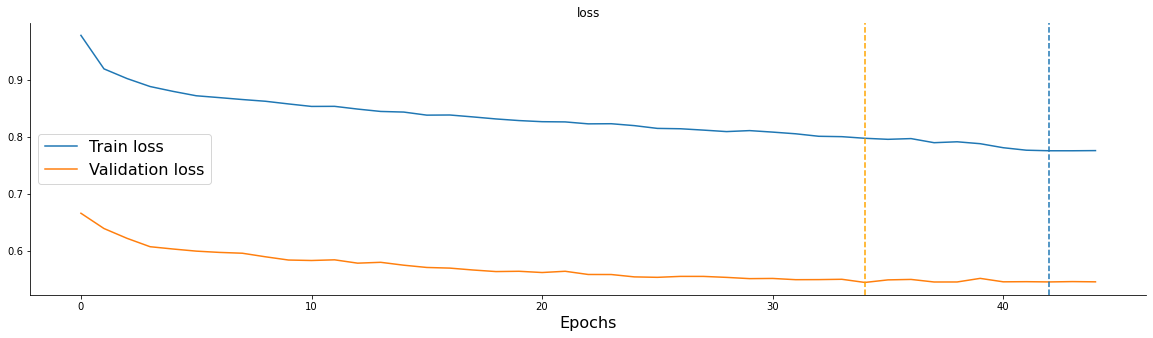


FOLD: 2
Train 0.68084 Validation 0.87776


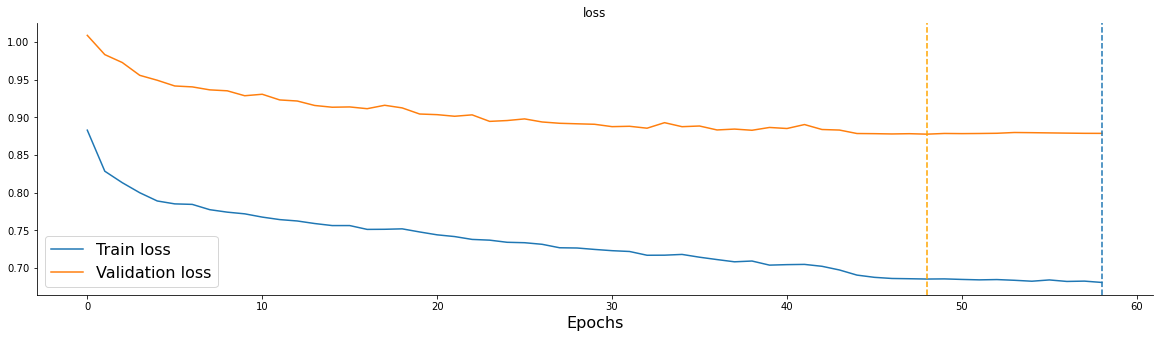


FOLD: 3
Train 0.71098 Validation 0.68697


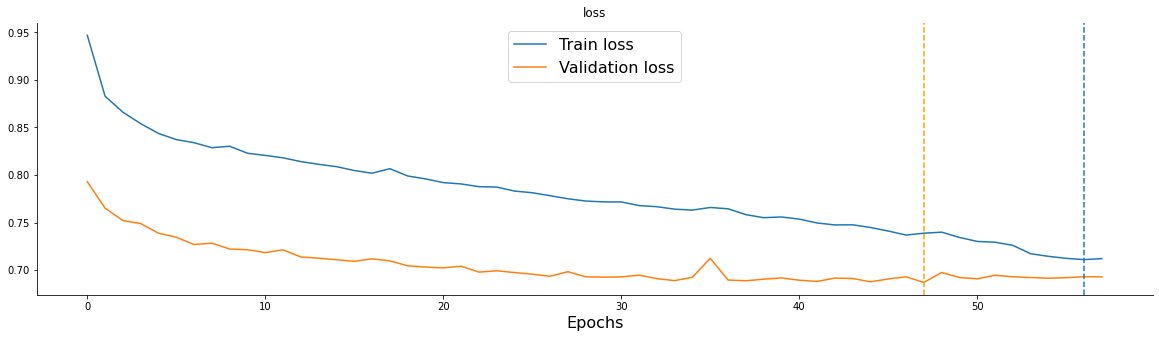


FOLD: 4
Train 0.71520 Validation 0.71815


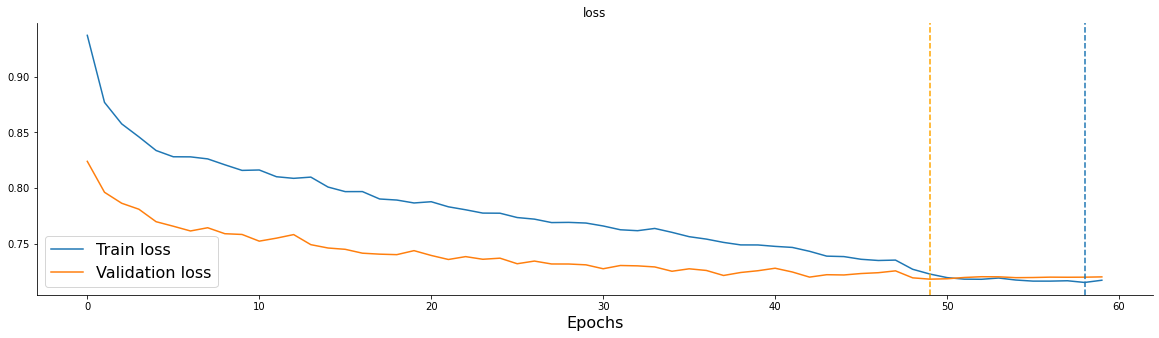


FOLD: 5
Train 0.68614 Validation 0.96214


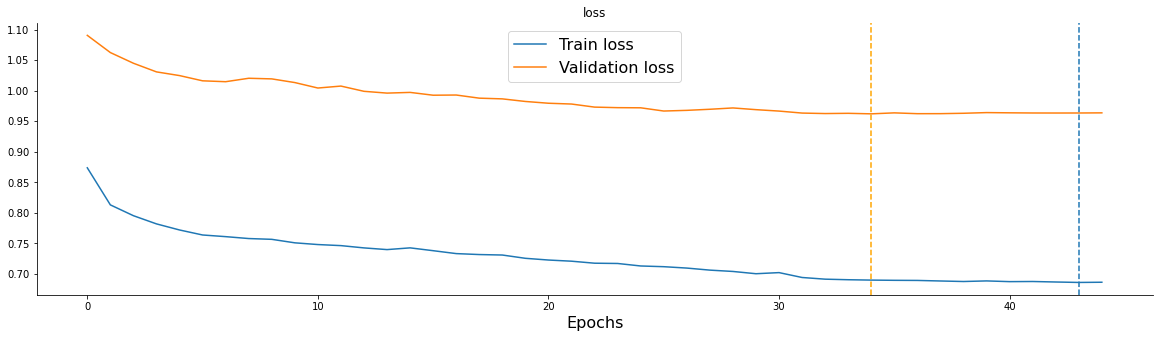

In [8]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    print(f"Train {np.array(history['loss']).min():.5f} Validation {np.array(history['val_loss']).min():.5f}")
    plot_metrics(history)

# Post-processing

In [9]:
preds_ls = []

for df, preds in [(public_test, test_public_preds), (private_test, test_private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=pred_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_ls.append(single_df)

preds_df = pd.concat(preds_ls)

# Model evaluation

# Visualize test predictions

In [10]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission = submission[['id_seqpos']].merge(preds_df, on=['id_seqpos'])

# Test set predictions

In [11]:
display(submission.head(10))
display(submission.describe())

submission.to_csv('submission.csv', index=False)

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.835705,0.688815,2.032068,0.568869,0.762515
1,id_00073f8be_1,2.504801,3.609105,4.478459,3.599277,2.884502
2,id_00073f8be_2,1.406002,0.653722,0.784364,0.750514,0.779088
3,id_00073f8be_3,1.397415,1.264186,1.346765,1.689299,1.526478
4,id_00073f8be_4,0.931032,0.688225,0.763657,0.925727,0.853906
5,id_00073f8be_5,0.521204,0.761331,0.900701,0.735104,0.726579
6,id_00073f8be_6,0.261307,0.538730,0.549212,0.434406,0.459000
7,id_00073f8be_7,0.247120,0.515078,0.602486,0.385223,0.583471
8,id_00073f8be_8,-0.025117,0.217604,0.214436,0.168455,0.155784
9,id_00073f8be_9,-0.022873,0.108265,0.136419,0.049758,0.138057


,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
count,457953.000000,457953.000000,457953.000000,457953.000000,457953.000000
mean,0.304281,0.400792,0.369030,0.337435,0.332725
std,0.345287,0.372504,0.419871,0.372466,0.332500
min,-0.612350,-0.825215,-1.778453,-1.319321,-2.167661
25%,0.067531,0.177370,0.148776,0.096248,0.124296
50%,0.189171,0.308155,0.287887,0.257788,0.270986
75%,0.444244,0.496687,0.464327,0.458377,0.473007
max,3.585357,4.115065,5.162014,4.135890,5.844042
